# 04 – Advanced Modeling (XGBoost) & Interpretability

Goal of this notebook:

- Inspect advanced models trained via the `src` pipeline:
  - XGBoost Regressor (RUL).
  - XGBoost Classifier (failure within horizon).
- Analyse feature importance.
- (Optional) Use SHAP for deeper explanations.



In [13]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from xgboost import XGBRegressor, XGBClassifier

# --- Paths / environment ---
project_root = Path.cwd().parent
sys.path.append(str(project_root))
print("Project root:", project_root)

plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.1)

models_dir = project_root / "models"
features_path = project_root / "data" / "processed" / "features_fd001.csv"

TARGET_RUL_COL = "RUL"
CLASS_LABEL_COL = "fail_within_horizon"
features_path, models_dir


Project root: /Users/arnavthakur/Documents/Data Science Projects/Industrial_Equipment_Failure_Prediction


(PosixPath('/Users/arnavthakur/Documents/Data Science Projects/Industrial_Equipment_Failure_Prediction/data/processed/features_fd001.csv'),
 PosixPath('/Users/arnavthakur/Documents/Data Science Projects/Industrial_Equipment_Failure_Prediction/models'))

In [14]:
df = pd.read_csv(features_path)
blacklist = {"unit", "cycle", TARGET_RUL_COL, CLASS_LABEL_COL}
feature_cols = [c for c in df.columns if c not in blacklist]

len(feature_cols), feature_cols[:5]


(138,
 ['setting_1_last', 'setting_2_last', 'setting_3_last', 's_2_mean', 's_2_std'])

In [15]:
lin_reg = joblib.load(models_dir / "linear_regression_rul.pkl")
xgb_reg = joblib.load(models_dir / "xgb_rul.pkl")
scaler = joblib.load(models_dir / "feature_scaler.pkl")

log_reg = joblib.load(models_dir / "logistic_failure.pkl")
xgb_clf = joblib.load(models_dir / "xgb_failure.pkl")

xgb_reg, xgb_clf


(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, ...),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, 

In [16]:
importance = xgb_reg.get_booster().get_score(importance_type="gain")

imp_df = pd.DataFrame(
    {"feature": list(importance.keys()), "gain": list(importance.values())}
).sort_values("gain", ascending=False)

imp_df.head(20)


,feature,gain
108,f111,425168.781250
72,f75,243645.562500
11,f12,101674.609375
66,f69,67964.359375
36,f39,60129.898438
67,f70,48819.855469
20,f21,27933.035156
63,f66,23607.318359
76,f79,22505.083984
23,f24,19077.281250


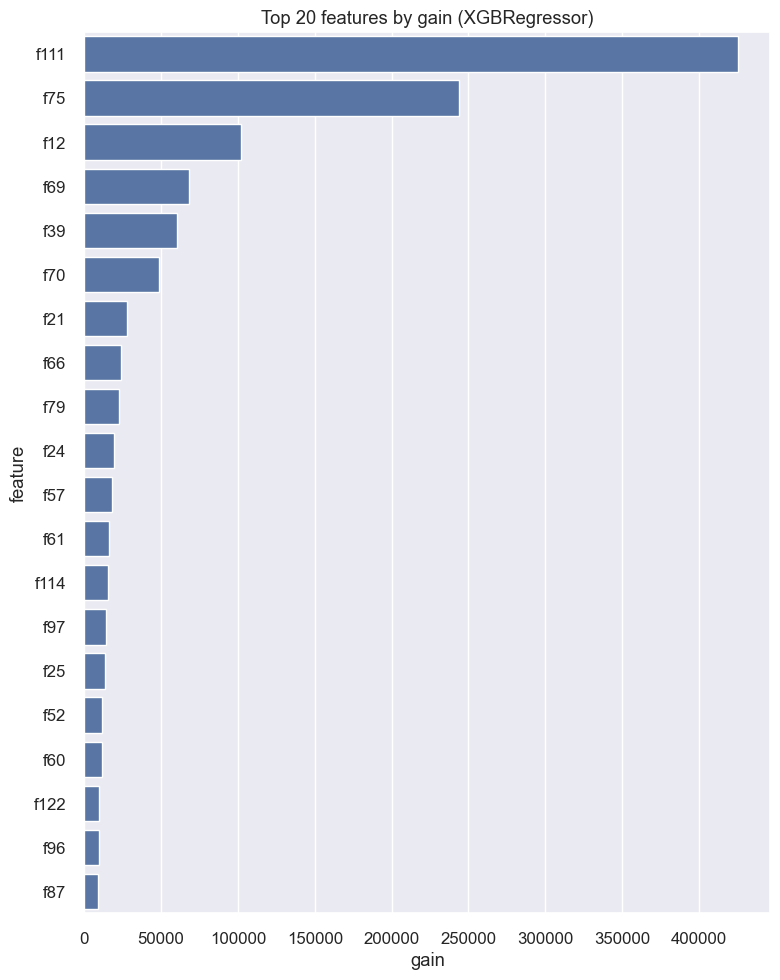

In [17]:
plt.figure(figsize=(8, 10))
sns.barplot(
    data=imp_df.head(20),
    y="feature",
    x="gain",
)
plt.title("Top 20 features by gain (XGBRegressor)")
plt.tight_layout()
plt.show()


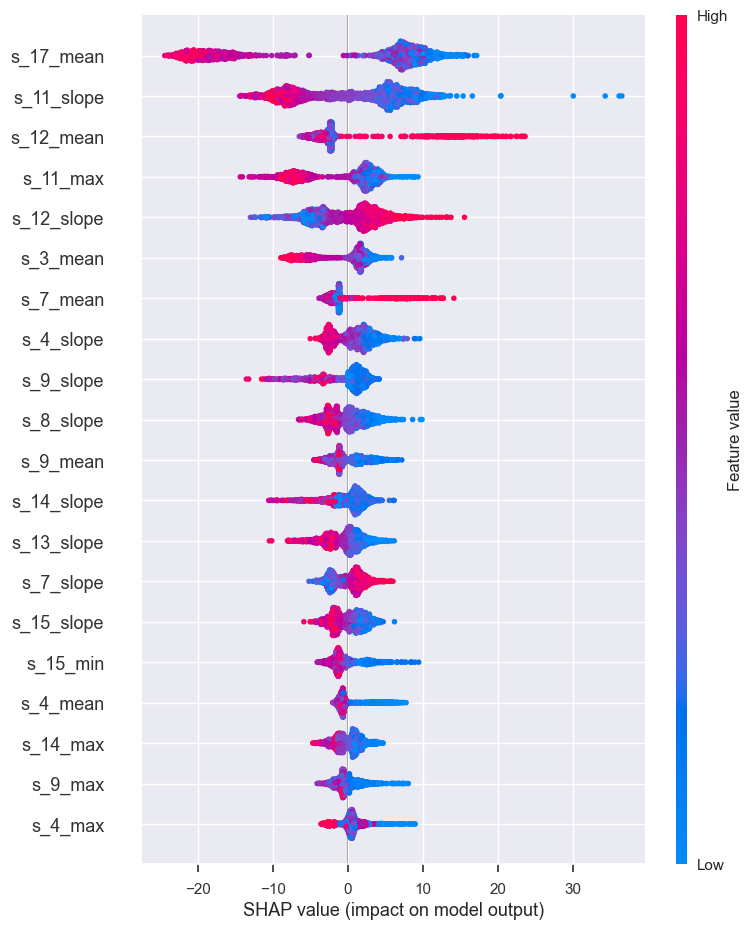

In [18]:

import shap

sample = df[feature_cols].sample(2000, random_state=42)
explainer = shap.TreeExplainer(xgb_reg)
shap_values = explainer.shap_values(sample)

shap.summary_plot(shap_values, sample, max_display=20)
